In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
tf.get_logger().setLevel('ERROR')


In [2]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_excel('ME & IE Department Data.xlsx', engine="openpyxl", sheet_name='Mechanical Engineering Summary ')

In [4]:
columns_map = {
    'University': 'University',
    '# of Faculty (5/12/23)': 'Number of Faculty',
    '# of Tenure (5/12/23)': 'Number of Tenure',
    'P1': 'P1',
    'ENROLLMENT (FULL-TIME) - 2023': 'Enrollment',
    'E2': 'E2',
    'Total funds - 2021': 'Total funds 2021',
    'Total funds - 2022': 'Total funds 2022',
    'AVERAGE QUANTITATIVE GRE - 2023': 'GRE Score',
    'ME Ranking - 2023': 'ME Ranking 2023',
    'ME Ranking - 2024': 'ME Ranking 2024'
}
data = df[list(columns_map.keys())].copy()
data.columns = list(columns_map.values())

In [5]:
def extract_rank(rank_str):
    if pd.isna(rank_str):
        return np.nan
    if isinstance(rank_str, str) and '#' in rank_str:
        match = re.search(r'#(\d+)', rank_str)
        if match:
            return int(match.group(1))
    try:
        return float(rank_str)
    except:
        return np.nan

In [6]:

data['ME Ranking 2023'] = data['ME Ranking 2023'].apply(extract_rank)
data['ME Ranking 2024'] = data['ME Ranking 2024'].apply(extract_rank)

In [7]:
data = data.dropna(subset=['ME Ranking 2023', 'ME Ranking 2024'])

In [8]:
data['Label'] = (data['ME Ranking 2024'] < data['ME Ranking 2023']).astype(int)

In [9]:
numerical_features = ['Number of Faculty', 'Number of Tenure', 'P1', 'Enrollment',
                      'E2', 'Total funds 2021', 'Total funds 2022', 'GRE Score', 'ME Ranking 2023']
for col in numerical_features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].fillna(data[col].mean())

In [10]:
from sklearn.cluster import KMeans

# KMeans-based Imputation for Invalid Funding 
bad_2021 = data['Total funds 2021'] <= 0
bad_2022 = data['Total funds 2022'] <= 0


valid_rows = ~(bad_2021 | bad_2022)
features_for_kmeans = data.loc[valid_rows, numerical_features]
kmeans = KMeans(n_clusters=3, random_state=12)
kmeans.fit(features_for_kmeans)

KMeans(n_clusters=3, random_state=12)

In [11]:
data['Cluster'] = kmeans.predict(data[numerical_features])

# Impute based on cluster
for cluster_id in np.unique(data['Cluster']):
    cluster_mask = data['Cluster'] == cluster_id

    # Impute Total funds 2021
    mean_2021 = data.loc[cluster_mask & ~bad_2021, 'Total funds 2021'].mean()
    data.loc[cluster_mask & bad_2021, 'Total funds 2021'] = mean_2021

    # Impute Total funds 2022
    mean_2022 = data.loc[cluster_mask & ~bad_2022, 'Total funds 2022'].mean()
    data.loc[cluster_mask & bad_2022, 'Total funds 2022'] = mean_2022

# Step 4: Drop cluster label
data = data.drop(columns=['Cluster'])

C:\Users\Ataheri\AppData\Local\Temp\ipykernel_14744\2080747303.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12837502.361111112' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[cluster_mask & bad_2021, 'Total funds 2021'] = mean_2021
C:\Users\Ataheri\AppData\Local\Temp\ipykernel_14744\2080747303.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17994359.512820512' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[cluster_mask & bad_2022, 'Total funds 2022'] = mean_2022


In [12]:
log_transform_cols = ['Enrollment', 'Total funds 2021', 'Total funds 2022']

for col in log_transform_cols:
    if (data[col] <= 0).any():
        print(f"Skipping log transform for {col} — contains non-positive values.")
    else:
        data[col] = np.log1p(data[col])
        print(f"Log-transformed: {col}")

Log-transformed: Enrollment
Log-transformed: Total funds 2021
Log-transformed: Total funds 2022


In [13]:
X = data[numerical_features]
y = data['Label']

from scipy.stats import zscore

z_scores = np.abs(zscore(X))
threshold = 3.0
non_outliers = (z_scores < threshold).all(axis=1)

# Apply filter
X = X[non_outliers]
y = y[non_outliers]

print(f"Removed {len(z_scores) - non_outliers.sum()} outliers. Remaining samples: {non_outliers.sum()}")

Removed 10 outliers. Remaining samples: 163


In [14]:
poly = PolynomialFeatures(degree=40, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

feature_names = poly.get_feature_names_out(numerical_features)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.15, stratify=y, random_state=21) # X_poly_filtered

In [16]:
X_train.shape[0]

138

In [17]:
from imblearn.over_sampling import RandomOverSampler

# Before scaling
ros = RandomOverSampler(random_state=222)
X_train, y_train = ros.fit_resample(X_train, y_train)

print("Class distribution:", np.bincount(y_train))



Class distribution: [73 73]


In [18]:
X_train.shape[0]

146

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infs in X_train_scaled:", np.isinf(X_train_scaled).sum())

NaNs in X_train_scaled: 0
Infs in X_train_scaled: 0


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the neural network with best trial parameters
best_nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3533316113774422),
    Dense(32, activation='relu'),
    Dropout(0.10179447781466523),
    Dense(16, activation='linear'),
    Dense(1)
])

best_nn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop_best = EarlyStopping(monitor='val_loss', patience=15)

history_best = best_nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop_best],
    verbose=2
)

Epoch 1/200
5/5 - 1s - 169ms/step - accuracy: 0.5137 - loss: 5.5247 - val_accuracy: 0.5600 - val_loss: 4.8364
Epoch 2/200
5/5 - 0s - 15ms/step - accuracy: 0.5000 - loss: 5.8365 - val_accuracy: 0.5200 - val_loss: 4.3769
Epoch 3/200
5/5 - 0s - 16ms/step - accuracy: 0.4658 - loss: 5.8042 - val_accuracy: 0.4400 - val_loss: 4.4810
Epoch 4/200
5/5 - 0s - 15ms/step - accuracy: 0.5000 - loss: 5.4325 - val_accuracy: 0.4400 - val_loss: 5.6654
Epoch 5/200
5/5 - 0s - 15ms/step - accuracy: 0.5137 - loss: 4.9434 - val_accuracy: 0.4400 - val_loss: 6.1911
Epoch 6/200
5/5 - 0s - 16ms/step - accuracy: 0.5411 - loss: 4.6943 - val_accuracy: 0.4000 - val_loss: 6.1755
Epoch 7/200
5/5 - 0s - 15ms/step - accuracy: 0.4726 - loss: 5.7694 - val_accuracy: 0.4000 - val_loss: 6.1750
Epoch 8/200
5/5 - 0s - 16ms/step - accuracy: 0.4795 - loss: 5.2532 - val_accuracy: 0.4000 - val_loss: 6.1727
Epoch 9/200
5/5 - 0s - 16ms/step - accuracy: 0.5205 - loss: 5.1696 - val_accuracy: 0.4000 - val_loss: 6.1729
Epoch 10/200
5/5 -

In [59]:
# Predict probabilities
nn_proba = best_nn_model.predict(X_test_scaled).flatten()

# Final prediction using best threshold
y_pred_final_nn = (nn_proba >= best_thresh_nn).astype(int)
auc_nn = roc_auc_score(y_test, nn_proba)

print(f"Neural Net Best Threshold: {best_thresh_nn:.2f}")
print(f"Neural Net Accuracy: {accuracy_score(y_test, y_pred_final_nn):.4f}")
print(f"Neural Net AUC: {auc_nn:.4f}")
print("\nNeural Net Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final_nn))
print("\nNeural Net Classification Report:")
print(classification_report(y_test, y_pred_final_nn, target_names=["Same/Declined", "Improved"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Neural Net Best Threshold: 0.37
Neural Net Accuracy: 0.6000
Neural Net AUC: 0.5577

Neural Net Confusion Matrix:
[[13  0]
 [10  2]]

Neural Net Classification Report:
               precision    recall  f1-score   support

Same/Declined       0.57      1.00      0.72        13
     Improved       1.00      0.17      0.29        12

     accuracy                           0.60        25
    macro avg       0.78      0.58      0.50        25
 weighted avg       0.77      0.60      0.51        25



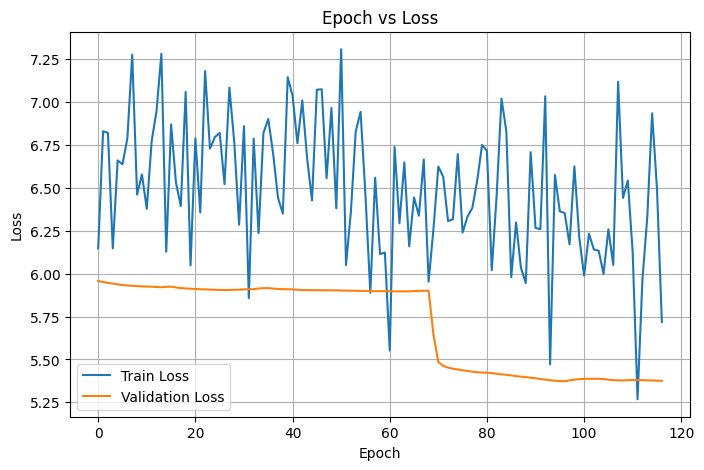

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Reconstruct prediction labels using the best threshold
best_pred = (y_proba >= best_thresh).astype(int)

# Create a copy of the test portion of the original data
summary_df = data.iloc[y_test.index].copy()

# Add predicted and actual class labels
summary_df['Predicted'] = np.where(best_pred == 1, "Improved", "Same/Declined")
summary_df['Actual'] = np.where(y_test == 1, "Improved", "Same/Declined")

# Select only the relevant columns for display
ranking_comparison_df = summary_df[['University', 'ME Ranking 2023', 'ME Ranking 2024', 'Actual', 'Predicted']]

# Display the comparison DataFrame
ranking_comparison_df


,University,ME Ranking 2023,ME Ranking 2024,Actual,Predicted
75,Illinois Institute of Technology (Armour),80,77.0,Improved,Improved
79,Oklahoma State University,87,77.0,Improved,Improved
145,Wright State University,151,146.0,Improved,Improved
62,University of Illinois--Chicago,61,63.0,Same/Declined,Same/Declined
8,University of Texas at Austin,11,9.0,Improved,Improved
162,Southern Illinois University--Carbondale,151,173.0,Same/Declined,Improved
123,New Mexico State University,124,131.0,Same/Declined,Improved
12,Northwestern University (McCormick),13,13.0,Same/Declined,Improved
143,University of Idaho,151,146.0,Improved,Improved
164,Northern Arizona University,166,173.0,Same/Declined,Same/Declined


In [ ]:
ranking_comparison_df[['University', 'ME Ranking 2023', 'ME Ranking 2024', 'Actual', 'Predicted']].to_csv("prediction_output_XGBoost.csv", index=False)